# Deep learning thực nghiệm 

# Thí nghiệm 4: Chuẩn hóa thang đo trong bài toán hồi quy


## BS. Lê Ngọc Khả Nhi

Trong bài thứ 4 của project "Deep learning thực nghiệm", Nhi sẽ thực hiện một thí nghiệm để đánh giá hiệu quả của việc chuẩn hóa hoặc hoán chuyển sang thang đo 0:1 cho features và/hoặc outcome, đối với độ chính xác của một mô hình mạng neuron hồi quy.

Trong các giáo trình về feature engineering, chúng ta thường được chỉ dẫn rằng đối với các mô hình mà sự biến thiên của outcome Y phụ thuộc trực tiếp vào giá trị của các features X thông qua một hàm tuyến tính, thì ta cần phải chuẩn hóa thang đo của X trước khi huấn luyện mô hình. Hai phương pháp chuẩn hóa thông dụng nhất đó là Standardisation (chuyển về thang đo Z-score), và chuẩn hóa về thang đo 0:1 (còn gọi là Minmax scaler), nếu không sẽ có nguy cơ là việc tiên lượng Y sẽ bị sai lệch khi 1 features nào đó có thang đo rời rạc, phân tán hoặc có outliers. Do bài toán hồi quy là trường hợp mà những vấn đề này bộc lộ ra một cách tiêu biểu nhất, chúng ta sẽ làm thí nghiệm trên một mô hình hồi quy, và sử dụng dữ liệu có thực chứ không phải mô phỏng như 3 thí nghiệm trước.

Trong thí nghiệm này, Nhi sẽ lần lượt dựng 9 mô hình hồi quy deep neural net khác nhau, dựa vào trainset với các đặc tính:

+ Không can thiệp gì cả lên X và Y
+ Chuẩn hóa X, giữ nguyên Y
+ Chuẩn hóa cả X và Y
+ Giữ nguyên X, chuẩn hóa Y
+ Hoán chuyển Min/Max, giữ nguyên Y
+ Hoán chuyển Min/Max cả X và Y
+ Giữ nguyên X, Hoán chuyển Min/Max cho Y
+ Hoán chuyển Min/Max, chuẩn hóa Y
+ Chuẩn hóa X và Hoán chuyển Min/Max cho Y

Và đánh giá hiệu quả của mô hình bằng chỉ số Trung vị của sai biệt tuyệt đối (MEDAE) trên testset.

Thí nghiệm được làm 1 lần, sau đó lặp lại 20 lần (bootstrap) để tính 97.5%CI của Medae.

In [133]:
# Package cơ bản
import pandas as pd
import numpy as np

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split  # Chia dữ liệu train/test
# Các hàm hoán chuyển 
from sklearn.preprocessing import *      
from sklearn.base import BaseEstimator, TransformerMixin 

from sklearn.pipeline import *  # Tạo pipeline

from sklearn.metrics import median_absolute_error as medae # Trung vị sai số tuyệt đối
from sklearn.utils import resample     # Bootstrap CV

# Deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

## Chuẩn bị hàm cho thí nghiệm

Đầu tiên,Nhi tải dữ liệu DLCO từng dùng cho loạt bài tự học keras. Bài toán hồi quy này có mục tiêu tiên lượng DLCO (outcome) từ 3 features: Sex, Age và Height.

Do dữ liệu có cả biến định tính và định lượng, Nhi sẽ dùng pipelines để xử lý cho từng trường hợp.

In [5]:
path="https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/DLCOkeras1.csv"
    
df=pd.read_csv(path, sep=';')

df.head()

,Sex,Age,Height,DLCO
0,F,20,173.0,29.2
1,F,22,165.0,26.3
2,F,22,168.6,27.9
3,F,23,164.0,25.4
4,F,24,170.0,29.3


In [4]:
# Chuẩn bị Pipeline

# Bộ phận tách biến đính tính và định lượng
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Hàm identity cho biến định lượng (không hoán chuyển gì cả)
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X, y=None):
        return X*1

# Pipeline hoán chuyển Minmax cho biến định lượng
num_minmax_pipeline = Pipeline([
        ('selector', DataFrameSelector(['Age','Height'])),
        ('range_scaler', MinMaxScaler())
    ])

# Pipeline chuẩn hóa cho biến định lượng
num_std_pipeline = Pipeline([
        ('selector', DataFrameSelector(['Age','Height'])),
        ('std_scaler', StandardScaler())
    ])

# Pipeline Identity cho biến định lượng
num_id_pipeline= Pipeline([
        ('selector', DataFrameSelector(['Age','Height'])),
        ('id_scaler', IdentityTransformer())
    ])

# Pipeline nhị phân hóa biến định tính
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(['Sex'])),
        ('cat_encoder', OrdinalEncoder()),
    ])

# Pipeline hoàn chỉnh, với hoán chuyển Minmax
full_minmax_pipeline = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
        ("num_pipeline", num_minmax_pipeline)
    ])

# Pipeline hoàn chỉnh, với hoán chuyển chuẩn hóa
full_std_pipeline = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
        ("num_pipeline", num_std_pipeline)
    ])

# Pipeline hoàn chỉnh, không hoán chuyển gì cả
full_id_pipeline = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
        ("id_pipeline", num_id_pipeline)
    ])

Tiếp theo, Nhi viết một hàm cho phép hoán chuyển dữ liệu theo 9 điều kiện nêu trên. Hàm này sẽ tách riêng features và outcome, phân chia thành trainset (80%), testset (20%), chuyển biến Sex thành giá trị nhị phân 0/1, sau đó tùy theo tùy chỉnh mà áp dụng các hàm hoán chuyển Standard scaler, Minmax scaler hay Identity cho các biến định lượng X và/hoặc Y.

In [37]:
def create_dataset(df=df,
                   output = 'DLCO',
                   test_ratio = 0.2,
                   seed = 123,
                   input_std= False,
                   input_range=False,
                   output_std=False,
                   output_range=False):
    # Tách input, output
    X,y = df.drop(output, axis=1), df['DLCO'].values
    # Chia dữ liệu thành Train/Test subset
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_ratio, 
                                                        random_state=seed)
    if not input_std and not input_range:
        # Không chuẩn hóa input
        X_train_id = full_id_pipeline.fit_transform(X_train)
        X_test_id = full_id_pipeline.fit_transform(X_test)
        train_feat = X_train_id
        test_feat = X_test_id
    if input_std and not input_range:
        # Chuẩn hóa input 
        X_train_std = full_std_pipeline.fit_transform(X_train)
        X_test_std = full_std_pipeline.fit_transform(X_test)
        train_feat = X_train_std
        test_feat = X_test_std
    if not input_std and input_range:
        # Hoán chuyển range cho input
        X_train_range = full_minmax_pipeline.fit_transform(X_train)
        X_test_range = full_minmax_pipeline.fit_transform(X_test)
        train_feat = X_train_range
        test_feat = X_test_range
    if output_std and not output_range:
        # Chuẩn hóa output
        y_train_std = StandardScaler().fit_transform(y_train.reshape(-1, 1)).reshape(-1,)
        y_test_std = StandardScaler().fit_transform(y_test.reshape(-1, 1)).reshape(-1,)
        train_out = y_train_std
        test_out = y_test_std
    if not output_std and output_range:
        # Range output
        y_train_range = MinMaxScaler().fit_transform(y_train.reshape(-1, 1)).reshape(-1,)
        y_test_range = MinMaxScaler().fit_transform(y_test.reshape(-1, 1)).reshape(-1,)
        train_out = y_train_range
        test_out = y_test_range
    if not output_std and not output_range:
        train_out = y_train
        test_out = y_test
    return y_train,y_test,train_feat,test_feat,train_out,test_out

Nhi chuẩn bị 1 hàm để vẽ biểu đồ theo dõi Training history cho mô hình.

In [14]:
def history_plot(history = None):
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['loss'],'b-',label='train')
    plt.plot(hist.history['val_loss'],'r--', label='test')
    plt.title('Model loss')
    plt.ylabel('Mean squared error')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Quan trọng hơn, ta cần 1 hàm cho phép kiểm định mô hình trên tập testset và ước tính giá trị Median absolute error. Lưu ý là hàm này sẽ phục hồi giá trị tiên lượng của DLCO theo thang đo gốc, ngay cả khi outcome này bị hoán chuyển bằng Minmax scaler hay Standard scaler, trước khi tính MEDAE score.

In [15]:
def test_model(model,
               y_train,y_test,
               test_feat,
               out_range=False,out_std=False):
    y_std_scaler=StandardScaler().fit(y_train.reshape(-1, 1))
    y_minmax_scaler=MinMaxScaler().fit(y_train.reshape(-1, 1))
    y_pred=model.predict(test_feat)
    if out_range and not out_std:
        y_pred = y_minmax_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1,)
    if out_std and not out_range:
        y_pred = y_std_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1,)
    score = medae(y_test,y_pred)
    return(score)

Cuối cùng, ta tạo ra hàm quan trọng nhất cho thí nghiệm, hàm này có công dụng xây dựng, huấn luyện mô hình Deep neuralnet trên trainset và kiểm định trên testset.

In [42]:
def deep_reg_experiment (out_range=False,out_std=False):
    
    # Xây dựng cấu trúc mạng neurone
    model = Sequential()
    model.add(Dense(32, input_dim=3, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Huấn luyện trên train_feat,train_output
    early_stop = EarlyStopping(monitor='val_loss', patience=20)
    
    hist = model.fit(train_feat,train_out,
                     epochs=500,
                     batch_size=16,
                     shuffle=True,
                     validation_data=(test_feat, test_out),              
                     callbacks=[early_stop],
                     verbose=0)
    # Kiểm định mô hình trên test set
    score = test_model(model,
                       y_train,y_test,
                       test_feat,
                       out_range=out_range,
                       out_std=out_std)
    print('Median abs error = %.5f' % score)
    return model, hist

### Mô hình 1: Không can thiệp gì cả lên X và Y

In [39]:
# Không can thiệp gì cả
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= False,
                                                                        input_range=False,
                                                                        output_std=False,
                                                                        output_range=False)

In [43]:
model, hist = deep_reg_experiment(out_range=False,out_std=False)

Median abs error = 3.08075


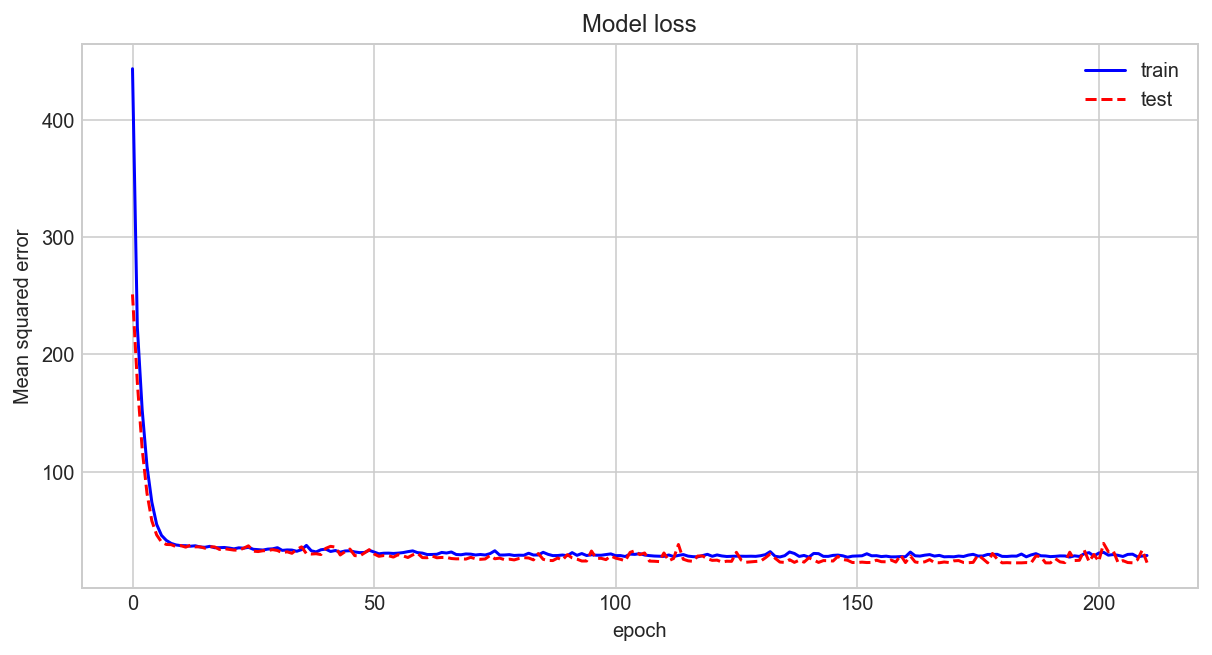

In [44]:
history_plot(history = hist)

### Mô hình 2: Chuẩn hóa X, giữ nguyên Y

In [45]:
# Chỉ chuẩn hóa features X
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= True,
                                                                        input_range=False,
                                                                        output_std=False,
                                                                        output_range=False)

model, hist = deep_reg_experiment(out_range=False,out_std=False)
history_plot(history = hist)

Median abs error = 3.06293


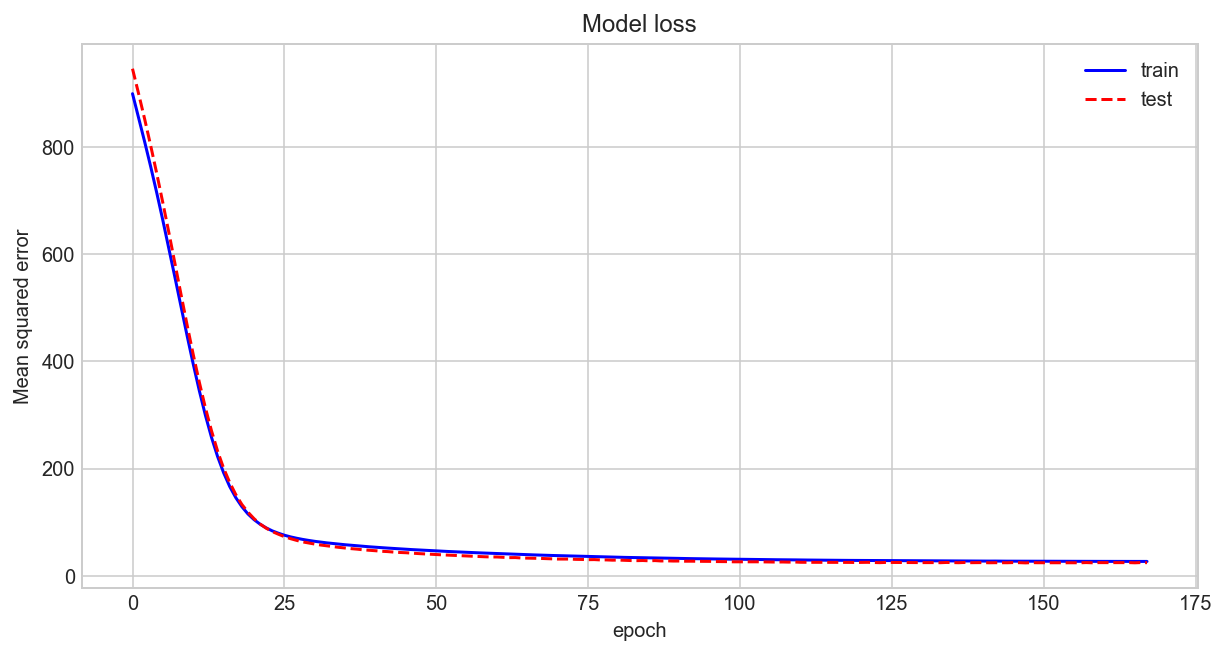

In [46]:
model, hist = deep_reg_experiment(out_range=False,out_std=False)
history_plot(history = hist)

### Mô hình 3: Hoán chuyển Min/Max cho X, giữ nguyên Y

Median abs error = 3.23591


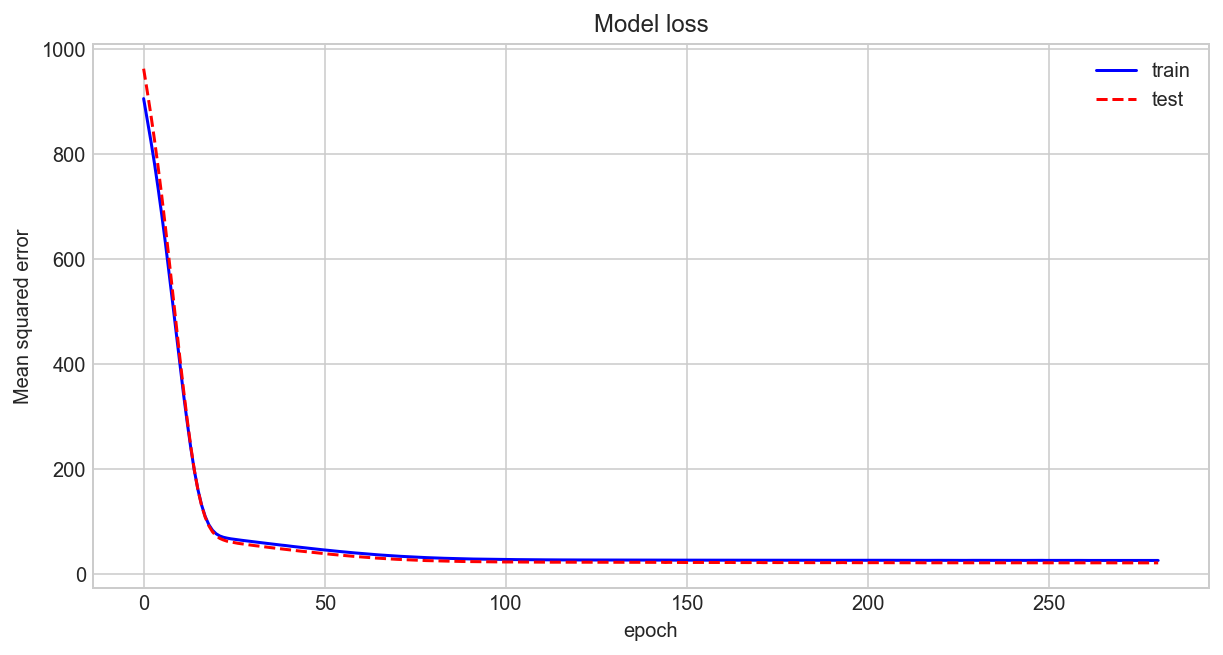

In [47]:
# Chỉ hoán chuyển Minmax cho features X
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= False,
                                                                        input_range=True,
                                                                        output_std=False,
                                                                        output_range=False)

model, hist = deep_reg_experiment(out_range=False,out_std=False)
history_plot(history = hist)

### Mô hình 4: Chuẩn hóa Y, nhưng không can thiệp gì lên X

Median abs error = 4.70159


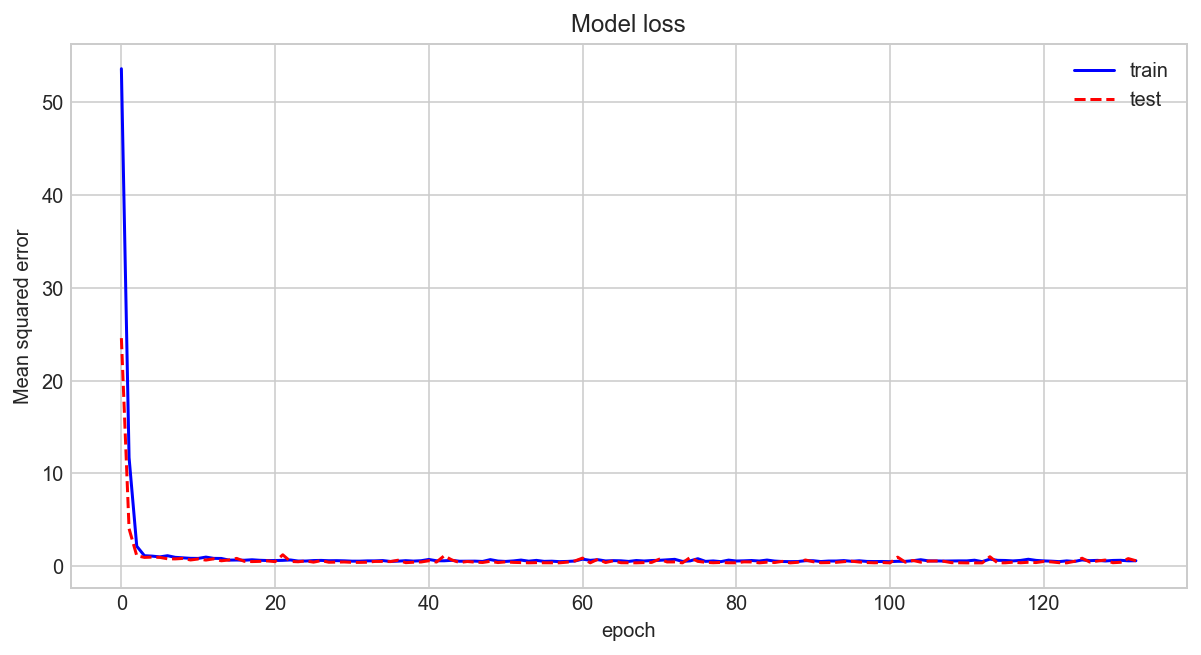

In [48]:
# Chuẩn hóa Y, nhưng không can thiệp gì lên X
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= False,
                                                                        input_range=False,
                                                                        output_std=True,
                                                                        output_range=False)

model, hist = deep_reg_experiment(out_range=False,out_std=True)
history_plot(history = hist)

### Mô hình 5: Hoán chuyển thang đo 0:1 cho Y nhưng không can thiệp gì lên X 

Median abs error = 6.85453


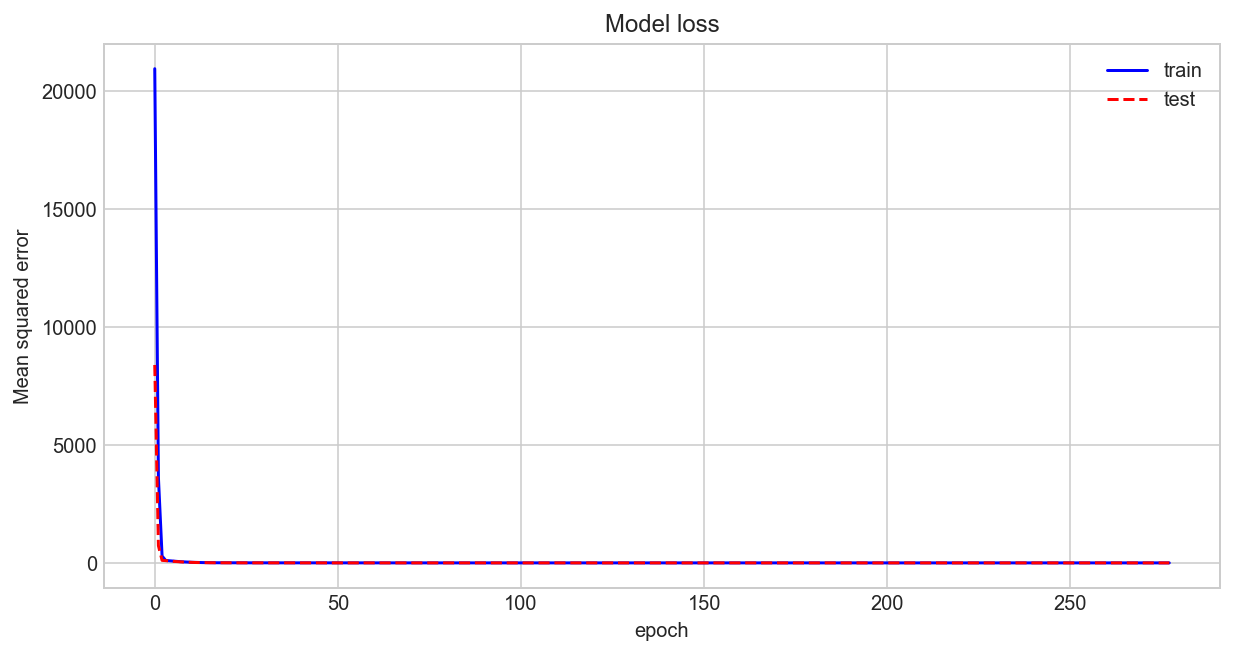

In [49]:
# Hoán chuyển Minmax cho Y, nhưng không can thiệp gì lên X
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= False,
                                                                        input_range=False,
                                                                        output_std=False,
                                                                        output_range=True)

model, hist = deep_reg_experiment(out_range=True,out_std=False)
history_plot(history = hist)

 ### Mô hình 6: Chuẩn hóa cả X và Y

Median abs error = 2.85895


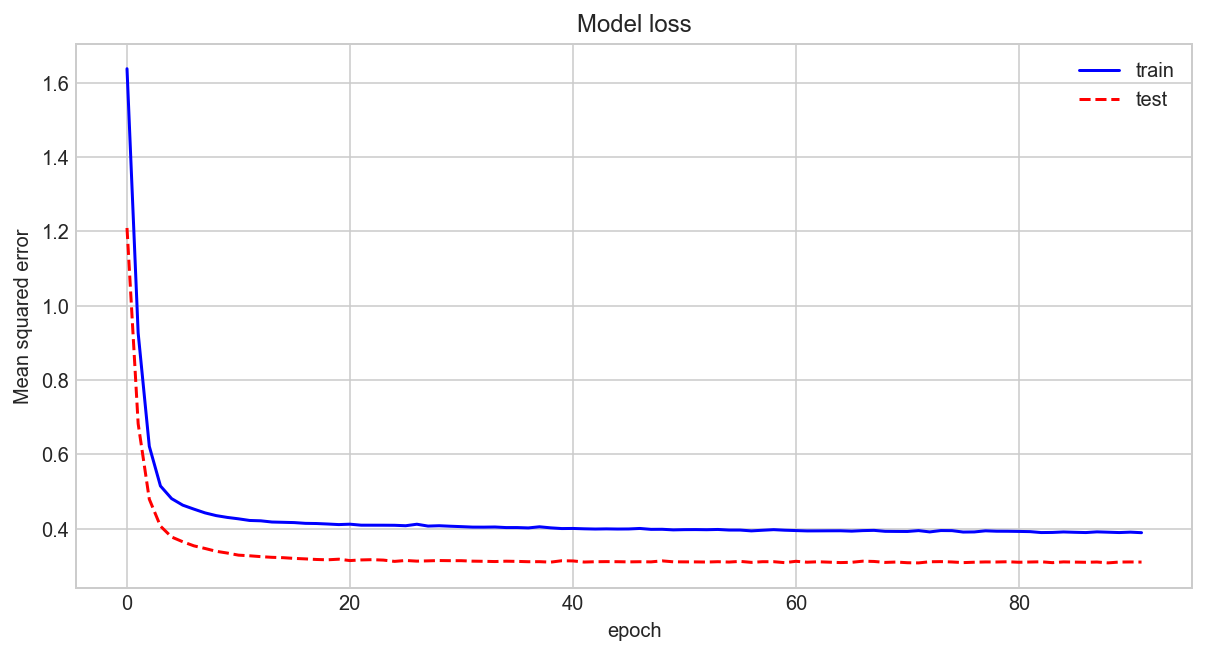

In [50]:
# Chuẩn hóa cả Y và X
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= True,
                                                                        input_range=False,
                                                                        output_std=True,
                                                                        output_range=False)

model, hist = deep_reg_experiment(out_range=False,out_std=True)
history_plot(history = hist)

### Mô hình 7: Hoán chuyển Min/max cho cả X và Y

Median abs error = 3.37856


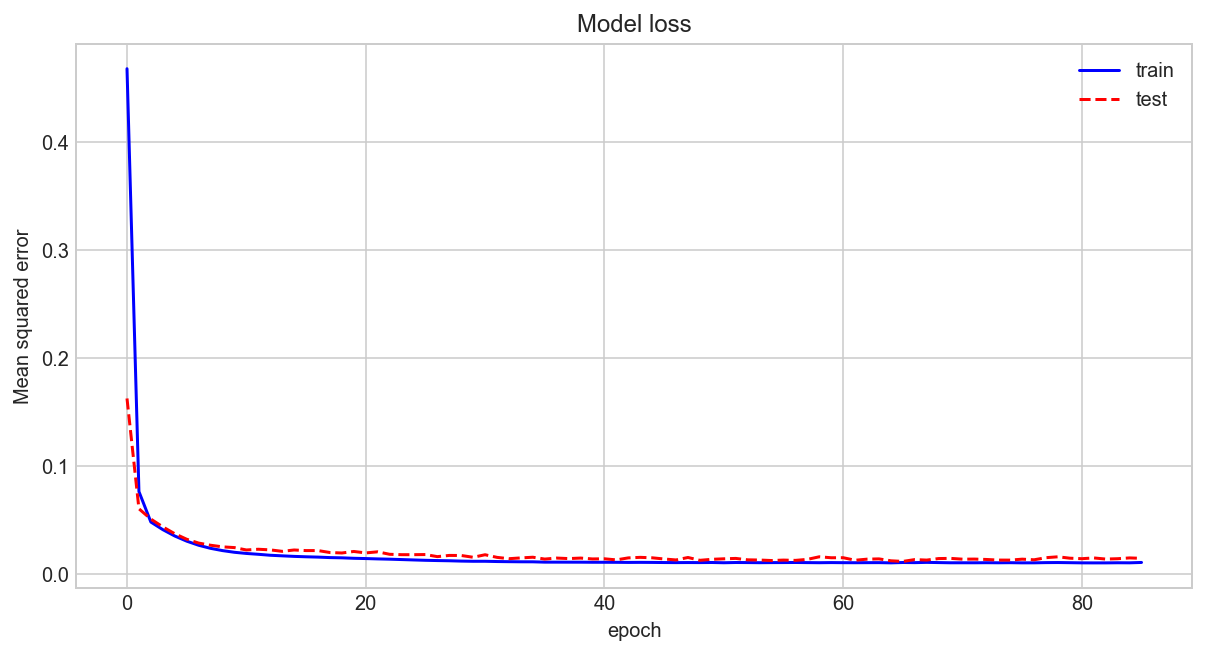

In [51]:
# Hoán chuyển minmax cả Y và X
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= False,
                                                                        input_range=True,
                                                                        output_std=False,
                                                                        output_range=True)

model, hist = deep_reg_experiment(out_range=True,out_std=False)
history_plot(history = hist)

### Mô hình 8: Chuẩn hóa Y và hoán chuyển Min-Max cho X

Median abs error = 3.33714


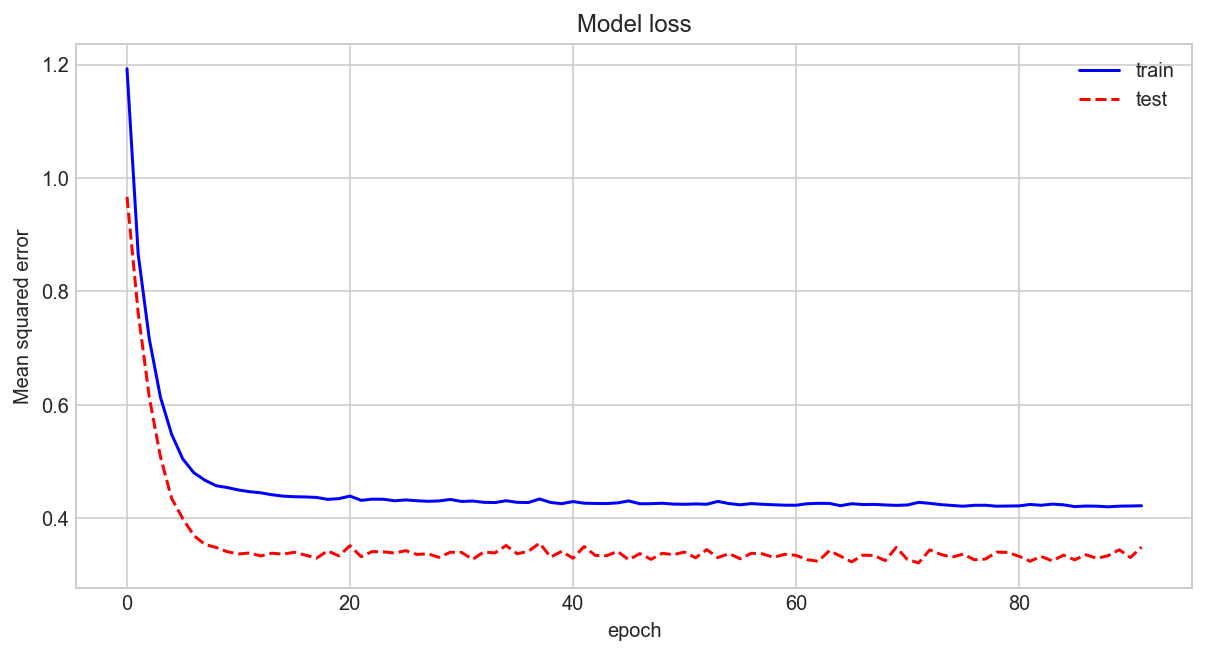

In [52]:
# Chuẩn hóa Y và hoán chuyển Min-Max cho X
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= False,
                                                                        input_range=True,
                                                                        output_std=True,
                                                                        output_range=False)

model, hist = deep_reg_experiment(out_range=False,out_std=True)
history_plot(history = hist)

### Mô hình 9: Chuẩn hóa X và hoán chuyển Min-Max cho Y

Median abs error = 3.37152


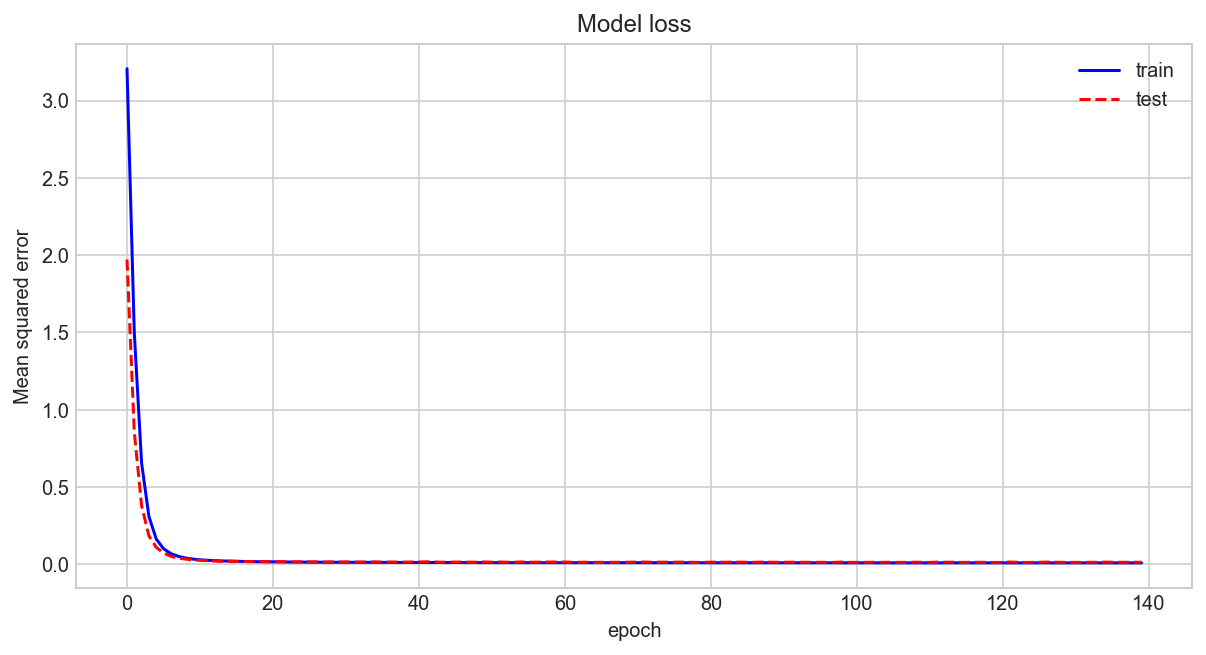

In [54]:
# Chuẩn hóa X và hoán chuyển Min-Max cho Y
y_train,y_test,train_feat,test_feat,train_out,test_out = create_dataset(df=df,
                                                                        output = 'DLCO',
                                                                        test_ratio = 0.2,
                                                                        seed = 123,
                                                                        input_std= True,
                                                                        input_range=False,
                                                                        output_std=False,
                                                                        output_range=True)

model, hist = deep_reg_experiment(out_range=True,out_std=False)
history_plot(history = hist)

## Lặp lại thí nghiệm trên với bootstrap

### Chuẩn bị hàm chọn mẫu bootstrap

Để chuẩn bị cho thí nghiệm lặp lại nhiều lần một mô hình trên các phiên bản dữ liệu train/test khác nhau được chọn ngẫu nhiên  , Nhi cải biên lại hàm create_dataset ở trên ở chỗ: thay vì dùng dataframe gốc, ta sẽ áp dụng một quy trình chọn mẫu ngẫu nhiên để tạo ra tập trainset, sau đó lấy những cases còn lại làm testset. Các hàm hoán chuyển được áp dụng trên train set và testset này như trên.

In [135]:
def create_boot_dataset(df=df,
                   output = 'DLCO',
                   test_ratio = 0.2,
                   input_std= False,
                   input_range=False,
                   output_std=False,
                   output_range=False):
    # bootstrap resample
    train_size = int(len(df) * (1-test_ratio))
    # Tách input, output
    X,y = df.drop(output, axis=1), df[output]
    # Bootstrap + Chia dữ liệu thành Train/Test subset
    X_train,y_train = resample(X,y,n_samples=train_size)
    y_train = y_train.values
    X_test=df.iloc[-X_train.index]
    y_test=df.iloc[-X_train.index]['DLCO'].values
    # Sơ chế dữ liệu
    if not input_std and not input_range:
        # Không chuẩn hóa input
        X_train_id = full_id_pipeline.fit_transform(X_train)
        X_test_id = full_id_pipeline.fit_transform(X_test)
        train_feat = X_train_id
        test_feat = X_test_id
    if input_std and not input_range:
        # Chuẩn hóa input 
        X_train_std = full_std_pipeline.fit_transform(X_train)
        X_test_std = full_std_pipeline.fit_transform(X_test)
        train_feat = X_train_std
        test_feat = X_test_std
    if not input_std and input_range:
        # Hoán chuyển range cho input
        X_train_range = full_minmax_pipeline.fit_transform(X_train)
        X_test_range = full_minmax_pipeline.fit_transform(X_test)
        train_feat = X_train_range
        test_feat = X_test_range
    if output_std and not output_range:
        # Chuẩn hóa output
        y_train_std = StandardScaler().fit_transform(y_train.reshape(-1, 1)).reshape(-1,)
        y_test_std = StandardScaler().fit_transform(y_test.reshape(-1, 1)).reshape(-1,)
        train_out = y_train_std
        test_out = y_test_std
    if not output_std and output_range:
        # Range output
        y_train_range = MinMaxScaler().fit_transform(y_train.reshape(-1, 1)).reshape(-1,)
        y_test_range = MinMaxScaler().fit_transform(y_test.reshape(-1, 1)).reshape(-1,)
        train_out = y_train_range
        test_out = y_test_range
    if not output_std and not output_range:
        train_out = y_train
        test_out = y_test
    return y_train,y_test,train_feat,test_feat,train_out,test_out

Tiếp theo, Nhi sẽ thay hàm create_data trong hàm deep_reg_experimentbằng hàm create_boot_dataset mới vừa tạo. Nhi cũng rút ngắn hàm này bằng cách lược bỏ phần history mà chỉ xuất trực tiếp MEDAE score.

In [136]:
def deep_reg_experiment(df=df,
                         output = 'DLCO',
                         inp_std= False,
                         inp_range=False,
                         out_std=False,
                         out_range=False):
    # Chọn mẫu Bootstrap
    y_train,y_test,train_feat,test_feat,train_out,test_out = create_boot_dataset(df=df,
                                                                                 output = output,
                                                                                 test_ratio = 0.2,
                                                                                 input_std= inp_std,
                                                                                 input_range=inp_range,
                                                                                 output_std=out_std,
                                                                                 output_range=out_range)
    # Xây dựng cấu trúc mạng neurone
    model = Sequential()
    model.add(Dense(32, input_dim=3, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Huấn luyện trên train_feat,train_output
    early_stop = EarlyStopping(monitor='val_loss', patience=20)
    
    model.fit(train_feat,train_out,
                     epochs=500,
                     batch_size=16,
                     shuffle=True,
                     validation_data=(test_feat, test_out),              
                     callbacks=[early_stop],
                     verbose=0)
    # Kiểm định mô hình trên test set
    score = test_model(model,
                       y_train,y_test,
                       test_feat,
                       out_range=out_range,
                       out_std=out_std)
    return (score)

### Bootstrap 1: Không can thiệp gì cả lên X và Y

In [161]:
iteration=20
model1_score = list()

print('-----------------------')
for resample_idx in range(iteration):
    score=deep_reg_experiment(df=df,
                         output = 'DLCO',
                         inp_std= False,
                         inp_range=False,
                         out_std=False,
                         out_range=False)
    model1_score.append(score)
    print('Sample N°=%d, Median abs error = %.5f' % (resample_idx, score))
    print('-----------------------')
    
np.quantile(model1_score,[0.025,0.975])

-----------------------
Sample N°=0, Median abs error = 3.11110
-----------------------
Sample N°=1, Median abs error = 3.09570
-----------------------
Sample N°=2, Median abs error = 3.17371
-----------------------
Sample N°=3, Median abs error = 3.13265
-----------------------
Sample N°=4, Median abs error = 3.12979
-----------------------
Sample N°=5, Median abs error = 3.39430
-----------------------
Sample N°=6, Median abs error = 2.86989
-----------------------
Sample N°=7, Median abs error = 2.97206
-----------------------
Sample N°=8, Median abs error = 3.42720
-----------------------
Sample N°=9, Median abs error = 3.11929
-----------------------
Sample N°=10, Median abs error = 3.09208
-----------------------
Sample N°=11, Median abs error = 2.97459
-----------------------
Sample N°=12, Median abs error = 3.09389
-----------------------
Sample N°=13, Median abs error = 3.62103
-----------------------
Sample N°=14, Median abs error = 2.98097
-----------------------
Sample N°=1

array([2.91842196, 3.52895731])

### Bootstrap 2: Chuẩn hóa X, giữ nguyên Y

In [163]:
iteration=20
model2_score = list()

print('-----------------------')
for resample_idx in range(iteration):
    score=deep_reg_experiment(df=df,
                         output = 'DLCO',
                         inp_std= True,
                         inp_range=False,
                         out_std=False,
                         out_range=False)
    model2_score.append(score)
    print('Sample N°=%d, Median abs error = %.5f' % (resample_idx, score))
    print('-----------------------')

np.quantile(model2_score,[0.025,0.975])

-----------------------
Sample N°=0, Median abs error = 2.96172
-----------------------
Sample N°=1, Median abs error = 3.23398
-----------------------
Sample N°=2, Median abs error = 2.98649
-----------------------
Sample N°=3, Median abs error = 2.96756
-----------------------
Sample N°=4, Median abs error = 2.82284
-----------------------
Sample N°=5, Median abs error = 3.26959
-----------------------
Sample N°=6, Median abs error = 3.01881
-----------------------
Sample N°=7, Median abs error = 2.95532
-----------------------
Sample N°=8, Median abs error = 2.90107
-----------------------
Sample N°=9, Median abs error = 3.19473
-----------------------
Sample N°=10, Median abs error = 2.88923
-----------------------
Sample N°=11, Median abs error = 3.40543
-----------------------
Sample N°=12, Median abs error = 2.97150
-----------------------
Sample N°=13, Median abs error = 3.12552
-----------------------
Sample N°=14, Median abs error = 3.30759
-----------------------
Sample N°=1

array([2.85437833, 3.45598723])

### Bootstrap 3: Chuẩn hóa cả Y và X

In [164]:
iteration=20
model3_score = list()

print('-----------------------')
for resample_idx in range(iteration):
    score=deep_reg_experiment(df=df,
                         output = 'DLCO',
                         inp_std= True,
                         inp_range=False,
                         out_std=True,
                         out_range=False)
    model3_score.append(score)
    print('Sample N°=%d, Median abs error = %.5f' % (resample_idx, score))
    print('-----------------------')

np.quantile(model3_score,[0.025,0.975])

-----------------------
Sample N°=0, Median abs error = 2.77602
-----------------------
Sample N°=1, Median abs error = 2.93309
-----------------------
Sample N°=2, Median abs error = 2.85472
-----------------------
Sample N°=3, Median abs error = 3.45055
-----------------------
Sample N°=4, Median abs error = 3.22301
-----------------------
Sample N°=5, Median abs error = 2.91284
-----------------------
Sample N°=6, Median abs error = 3.18451
-----------------------
Sample N°=7, Median abs error = 2.94086
-----------------------
Sample N°=8, Median abs error = 3.12707
-----------------------
Sample N°=9, Median abs error = 2.98094
-----------------------
Sample N°=10, Median abs error = 3.34478
-----------------------
Sample N°=11, Median abs error = 3.03400
-----------------------
Sample N°=12, Median abs error = 2.91512
-----------------------
Sample N°=13, Median abs error = 3.09015
-----------------------
Sample N°=14, Median abs error = 2.92359
-----------------------
Sample N°=1

array([2.81339898, 3.40030997])

### Bootstrap 4: Hoán chuyển 0:1 cho X, chuẩn hóa Y

In [165]:
iteration=20
model4_score = list()

print('-----------------------')
for resample_idx in range(iteration):
    score=deep_reg_experiment(df=df,
                         output = 'DLCO',
                         inp_std= False,
                         inp_range=True,
                         out_std=True,
                         out_range=False)
    model4_score.append(score)
    print('Sample N°=%d, Median abs error = %.5f' % (resample_idx, score))
    print('-----------------------')

np.quantile(model4_score,[0.025,0.975])

-----------------------
Sample N°=0, Median abs error = 3.13130
-----------------------
Sample N°=1, Median abs error = 3.12139
-----------------------
Sample N°=2, Median abs error = 3.21918
-----------------------
Sample N°=3, Median abs error = 3.01488
-----------------------
Sample N°=4, Median abs error = 3.14493
-----------------------
Sample N°=5, Median abs error = 3.41648
-----------------------
Sample N°=6, Median abs error = 2.85956
-----------------------
Sample N°=7, Median abs error = 2.96698
-----------------------
Sample N°=8, Median abs error = 3.16986
-----------------------
Sample N°=9, Median abs error = 3.03614
-----------------------
Sample N°=10, Median abs error = 3.10155
-----------------------
Sample N°=11, Median abs error = 3.08207
-----------------------
Sample N°=12, Median abs error = 2.97187
-----------------------
Sample N°=13, Median abs error = 3.15862
-----------------------
Sample N°=14, Median abs error = 2.99447
-----------------------
Sample N°=1

array([2.90686431, 3.36216357])

### Bootstrap 5: Hoán chuyển 0:1 cho cả Y và X

In [166]:
iteration=20
model5_score = list()

print('-----------------------')
for resample_idx in range(iteration):
    score=deep_reg_experiment(df=df,
                         output = 'DLCO',
                         inp_std= False,
                         inp_range=True,
                         out_std=False,
                         out_range=True)
    model5_score.append(score)
    print('Sample N°=%d, Median abs error = %.5f' % (resample_idx, score))
    print('-----------------------')

np.quantile(model5_score,[0.025,0.975])

-----------------------
Sample N°=0, Median abs error = 2.97221
-----------------------
Sample N°=1, Median abs error = 2.80709
-----------------------
Sample N°=2, Median abs error = 3.61751
-----------------------
Sample N°=3, Median abs error = 2.93988
-----------------------
Sample N°=4, Median abs error = 3.02772
-----------------------
Sample N°=5, Median abs error = 3.55561
-----------------------
Sample N°=6, Median abs error = 3.02933
-----------------------
Sample N°=7, Median abs error = 3.36224
-----------------------
Sample N°=8, Median abs error = 2.98784
-----------------------
Sample N°=9, Median abs error = 2.73109
-----------------------
Sample N°=10, Median abs error = 3.23141
-----------------------
Sample N°=11, Median abs error = 2.98046
-----------------------
Sample N°=12, Median abs error = 2.98795
-----------------------
Sample N°=13, Median abs error = 3.44373
-----------------------
Sample N°=14, Median abs error = 3.00378
-----------------------
Sample N°=1

array([2.76719031, 3.58810472])

## Kết luận

Qua các thí nghiệm trên, Nhi có một số cảm nhận như sau:

+ Việc chuẩn hóa hoặc hoán chuyển sang thang đo 0:1 cho features X có hiệu quả tích cực, làm giảm sai số cho mô hình Deep learning hồi quy. 

+ Tuy nhiên, bộ dữ liệu này không cho thấy sự tương phản rõ nét giữa các phiên bản mô hình có hay không sự chuẩn hóa thang đo cho X và/hoặc Y; nguyên nhân có thể vì : 
1) Outcome DLCO có phân bố chuẩn trong mẫu, 
2) Dữ liệu được thu thập khá tốt, không có hiện tượng mất cân đối, rời rạc hay phân tán ở cả features lẫn outcome, 
3) Đây là dữ liệu sinh lý và nhân trắc, sự biến thiên không quá ngẫu nhiên, bất ngờ và quá lớn như những đại lượng khác trong cuộc sống;

+ Không có khác biệt rõ nét giữa 2 phương pháp: hoán chuyển Minmax (0:1) và chuẩn hóa, chúng gần như tương đương.

+ Việc hoán chuyển/ chuẩn hóa cho features có vai trò quan trọng hơn so với cho outcome. Việc hoán chuyển outcome có thể gây khó khăn phức tạp khi ứng dụng mô hình vì cần có thêm 1 hàm phục hồi (hoán chuyển ngược) thang đo cho giá trị ước lượng của Y.

Chúc các bạn thực hành vui, tạm biệt và hẹn gặp lại trong thí nghiệm khác vào lần tới.